# Filling the Gaps When the World Goes Off Script:  
## Comparative Evaluation of Imputation and Counterfactual Forecasting Methods for Extraordinary Periods in Air Travel Data

What happens when the world suddenly stops flying? The COVID-19 pandemic created an extraordinary disruption in global air travel, with international passenger volumes dropping sharply from early 2020. While data collection generally continued throughout the pandemic, the period provides a valuable test case for evaluating how different imputation and forecasting methods perform during unprecedented events.

In this project, I analyze monthly departing international passenger data from 2016 to 2024. I deliberately mask the main COVID period to simulate a scenario where critical business data is missing or unreliable during a major shock. The objective is to compare several approaches—including classical imputation, counterfactual forecasting, and event-aware modeling—to determine which methods most accurately reconstruct the extraordinary period.

The findings are relevant for any organization that needs to fill data gaps, estimate business impact, or forecast under uncertainty when faced with regime shifts or unexpected disruptions.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

## Let's explore the data first!

The dataset is from https://www.kaggle.com/datasets/pherzyjohndiez/philippine-flight-data-naia-2016-to-2024/data.

It consists of monthly records of air travel activity at [Country/Region or specific airports, if applicable] from January 2016 through December 2024. Each row represents aggregated totals for a calendar month and includes the following columns:

- `date`: Month and year (timestamp)
- `departing_international_flights`: Number of international flights departing
- `arriving_international_flights`: Number of international flights arriving
- `departing__international_passengers`: Number of passengers departing on international flights
- `arriving_international_passengers`: Number of passengers arriving on international flights
- `departing_domestic_flights`: Number of domestic flights departing
- `arriving_domestic_flights`: Number of domestic flights arriving
- `departing__domestic_passengers`: Number of passengers departing on domestic flights
- `arriving_domestic_passengers`: Number of passengers arriving on domestic flights

The dataset tracks several different time series. But for this project, I'm zooming in on departing international passengers for the following reasons:

*   **Business impact**:  International travel is a key driver for airport revenue and long-term growth. Understanding how it was disrupted (and how it recovered) has big implications for business planning and policy.
*  **Room for meaningful analysis**: By focusing on the most affected series, I can really test and compare different imputation and counterfactual forecasting techniques, seeing how they perform under the toughest conditions.
* **Personal decision**: I initially debated between domestic and international but decided on international since the airport is afterall called, NA**I**A
 hehe.

No major gaps or missing values are present in the original data; however, for the purpose of evaluating imputation and forecasting methods, the COVID period (2020–2021) is intentionally masked to simulate an extraordinary scenario.

In [ ]:
df = pd.read_csv('flight_data_naia.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

df.head(3)

,departing_international_flights,arriving_international_flights,departing__international_passengers,arriving_international_passengers,departing_domestic_flights,arriving_domestic_flights,departing__domestic_passengers,arriving_domestic_passengers
date,,,,,,,,
2016-01-01,4323,4351,921618,765773,6617,6608,839710,938484
2016-02-01,4077,4108,788340,695343,6216,6201,821177,856096
2016-03-01,4323,4359,793846,830096,6693,6682,884743,853194


In [ ]:
print(df.isnull().sum())

departing_international_flights        0
arriving_international_flights         0
departing__international_passengers    0
arriving_international_passengers      0
departing_domestic_flights             0
arriving_domestic_flights              0
departing__domestic_passengers         0
arriving_domestic_passengers           0
dtype: int64


In [ ]:
df.shape

(108, 8)

In [ ]:
series_names = [
    'departing_international_flights', 'arriving_international_flights',
    'departing__international_passengers', 'arriving_international_passengers',
    'departing_domestic_flights', 'arriving_domestic_flights',
    'departing__domestic_passengers', 'arriving_domestic_passengers'
]

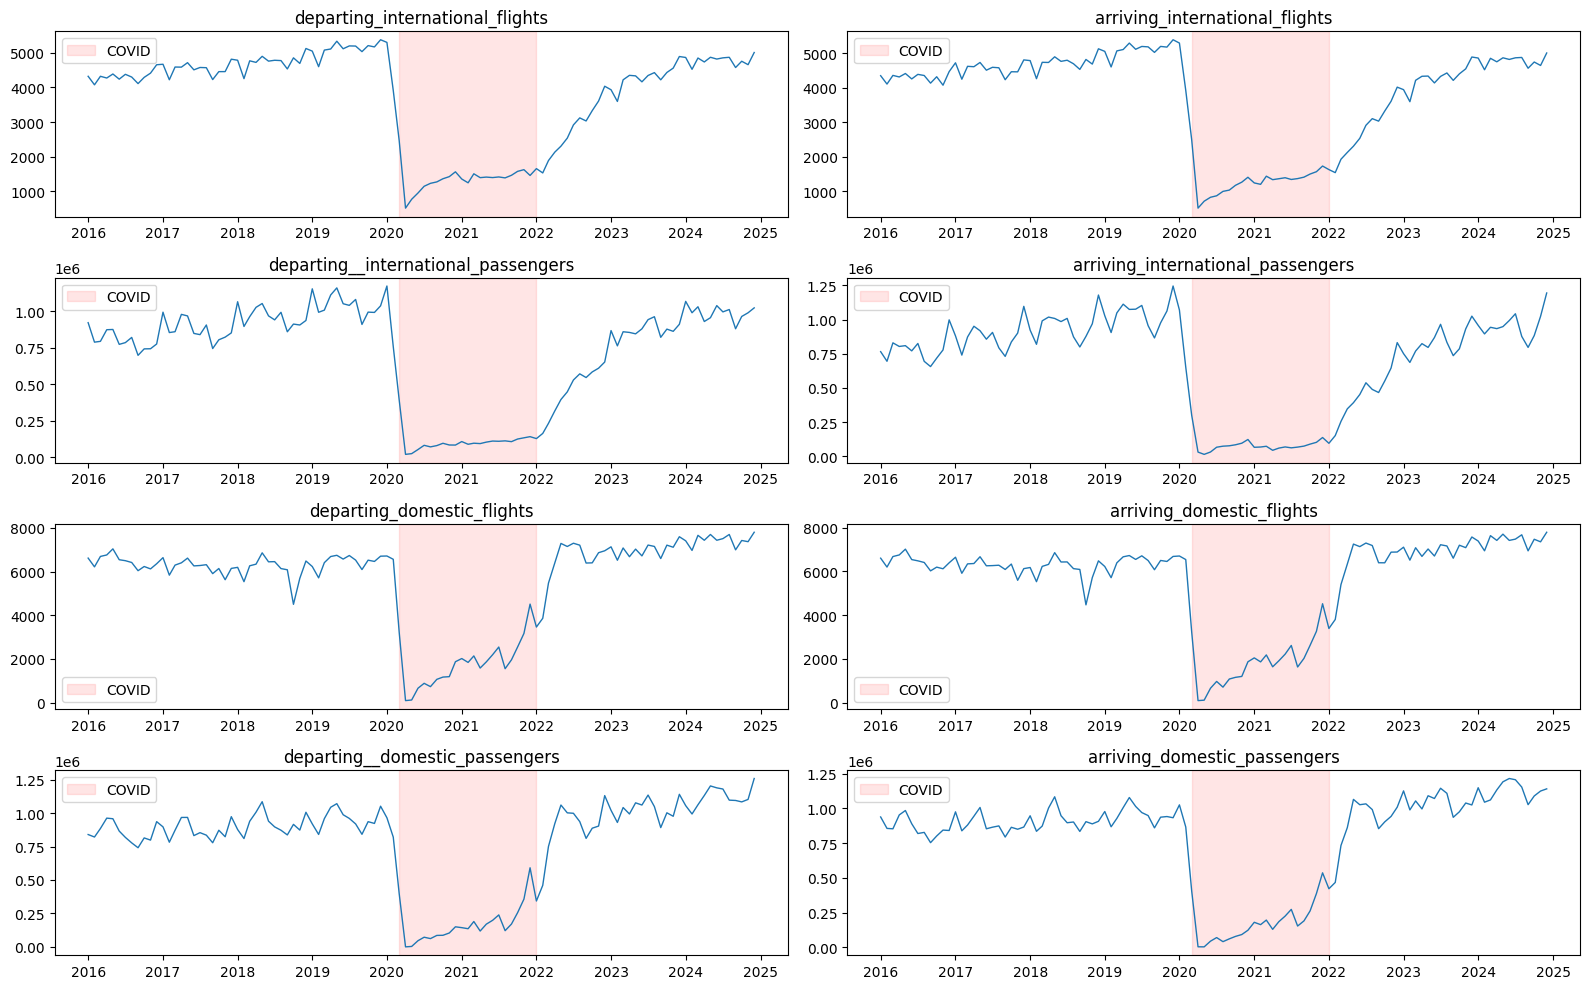

In [ ]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(series_names, 1):
    plt.subplot(4, 2, i)
    plt.plot(df.index, df[col], linewidth=1)
    plt.title(col)
    plt.axvspan('2020-03-01', '2021-12-31', color='red', alpha=0.1, label='COVID')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def plot_decomposition_with_correlogram(
    series,
    model='additive',
    period=12,
    title=None,
    covid_highlight=True,
    covid_start='2020-03-01',
    covid_end='2021-12-31',
    lags=36
):
    """
    Plots classical time series decomposition (4 panels) + ACF/PACF (2 panels) for a pandas Series.

    Parameters:
        series (pd.Series): Time series to decompose (datetime index).
        model (str): 'additive' or 'multiplicative'.
        period (int): Seasonality period (12 for monthly data).
        title (str): Main title.
        covid_highlight (bool): Highlight COVID period if True.
        covid_start (str): COVID period start (YYYY-MM-DD).
        covid_end (str): COVID period end (YYYY-MM-DD).
        lags (int): Lags to show in ACF/PACF.
    """
    res = seasonal_decompose(series, model=model, period=period)
    df_dcmp = pd.DataFrame({
        'ds': series.index,
        'data': series.values,
        'trend': res.trend,
        'seasonal': res.seasonal,
        'resid': res.resid
    })

    fig = plt.figure(constrained_layout=True, figsize=(14, 16))
    gs = fig.add_gridspec(6, 1)

    axes = [fig.add_subplot(gs[i, 0]) for i in range(6)]

    axes[0].plot(df_dcmp['ds'], df_dcmp['data'], color='blue')
    axes[0].set_ylabel('Data')
    axes[0].set_title('Observed')

    axes[1].plot(df_dcmp['ds'], df_dcmp['trend'], color='orange')
    axes[1].set_ylabel('Trend')
    axes[1].set_title('Trend')

    axes[2].plot(df_dcmp['ds'], df_dcmp['seasonal'], color='green')
    axes[2].set_ylabel('Seasonal')
    axes[2].set_title('Seasonal')

    axes[3].plot(df_dcmp['ds'], df_dcmp['resid'], color='red')
    axes[3].set_ylabel('Residual')
    axes[3].set_title('Residuals')
    axes[3].set_xlabel('Date')

    plot_acf(series.dropna(), lags=lags, ax=axes[4])
    axes[4].set_title('Autocorrelation (ACF)')
    plot_pacf(series.dropna(), lags=lags, ax=axes[5])
    axes[5].set_title('Partial Autocorrelation (PACF)')

    main_title = title or f"Decomposition and Correlogram"
    fig.suptitle(main_title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

/tmp/ipython-input-4109666915.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


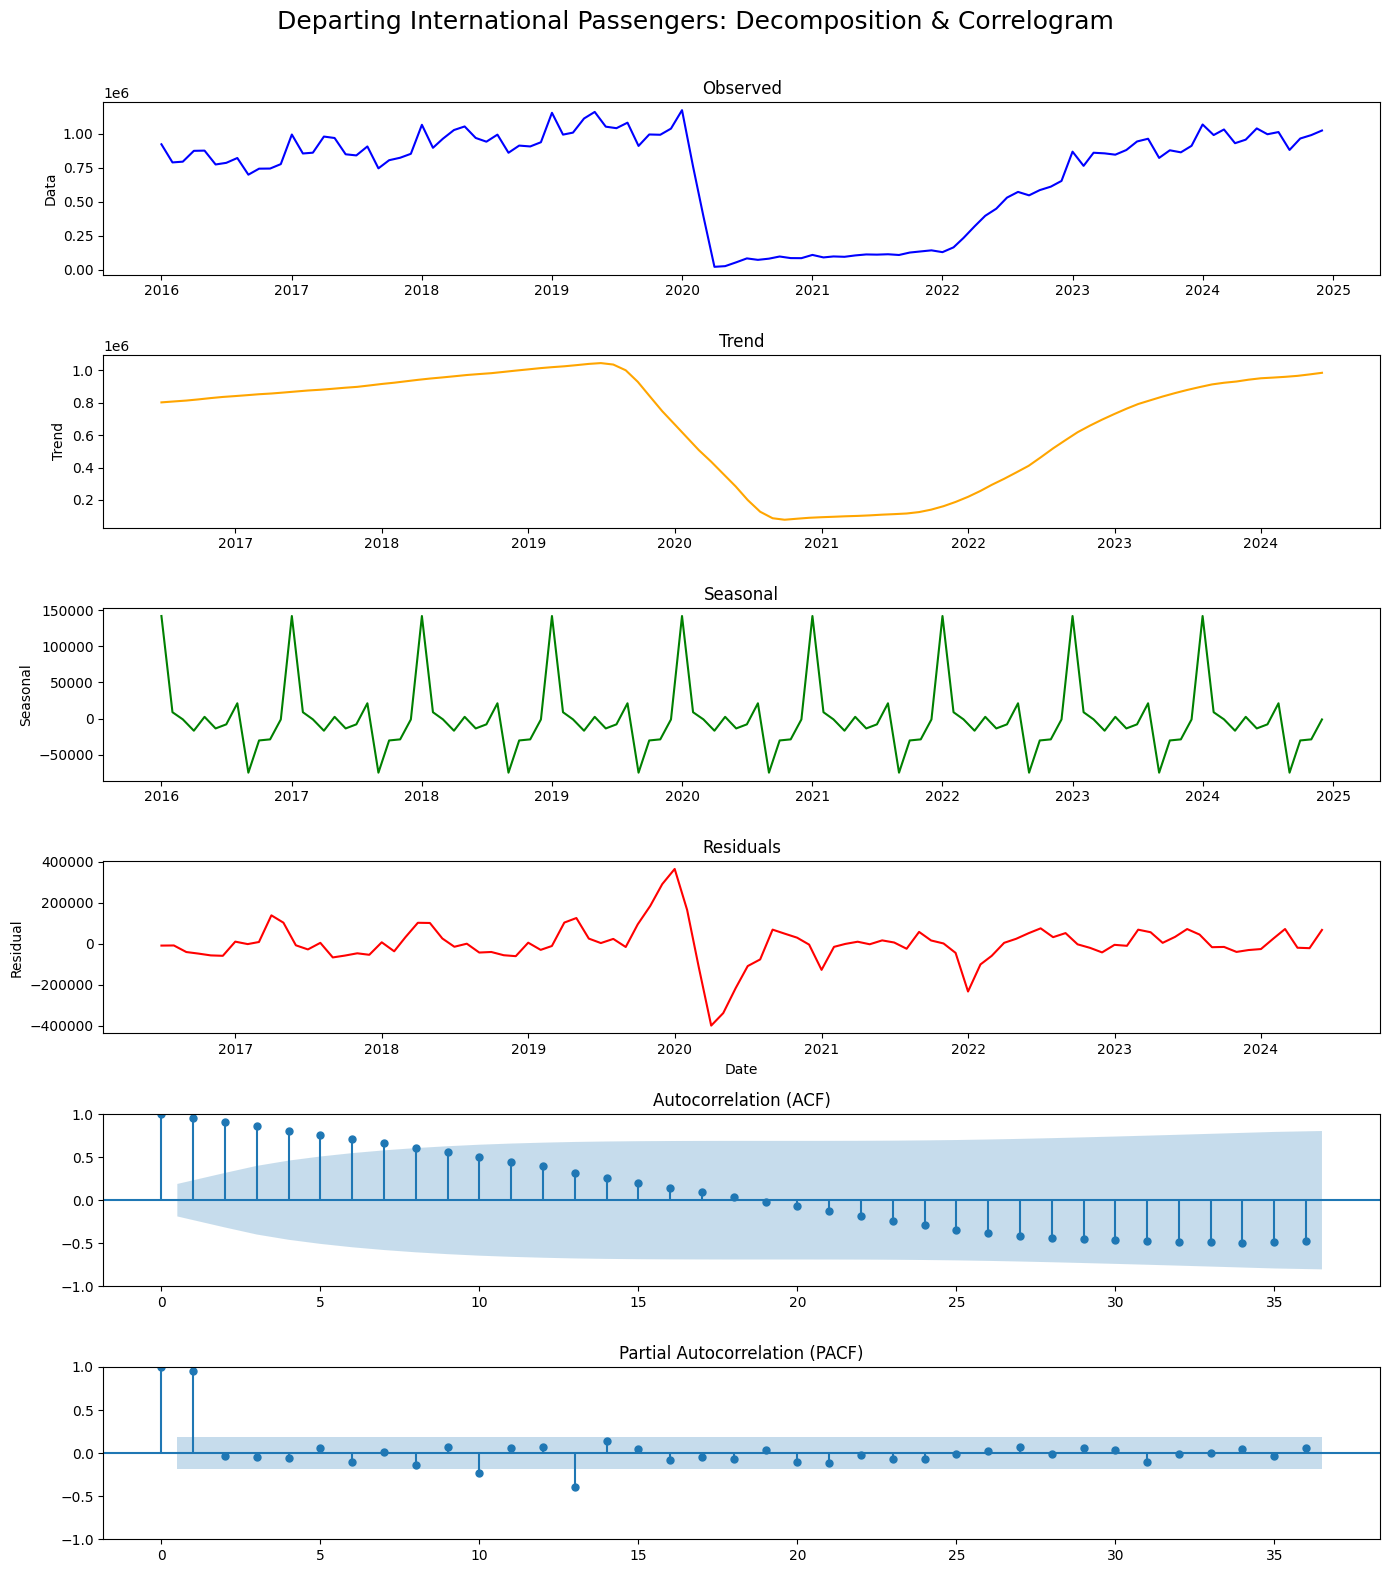

In [ ]:
plot_decomposition_with_correlogram(
    df['departing__international_passengers'],
    title='Departing International Passengers: Decomposition & Correlogram'
)

### What the plots tell us about air travel
<ul>
  <li>
    <strong>Pre-pandemic (2016–early 2020):</strong>
    The series shows steady, robust growth in departing international passenger volumes, with strong and regular annual peaks and troughs. This indicates a healthy and predictable international travel market, crucial for planning airport capacity, staffing, and retail operations.
  </li>
  <li>
    <strong>Pandemic onset (March 2020):</strong>
    There is a sudden, unprecedented collapse in international passenger numbers, dropping to near-zero and remaining at minimal levels for almost two years. This represents an extraordinary shock—far beyond any prior seasonal or trend-driven fluctuations.
  </li>
  <li>
    <strong>Recovery period (2022 onward):</strong>
    International travel only begins to recover gradually after 2022, with volumes still trailing pre-pandemic trends. This slow rebound has significant implications for business strategy, resource allocation, and revenue forecasts in international segments.
  </li>
</ul>


### How do these guide our analysis moving forward?
<ul>
  <li>
    <strong>Trend and Seasonality:</strong>
    The strong pre-pandemic trend and seasonality confirm that models like SARIMA or Holt-Winters are appropriate. These models can project what would have happened in the absence of the pandemic, providing valuable counterfactual forecasts.
  </li>
  <li>
    <strong>Extraordinary Event Detection:</strong>
    The large, unexplained residuals during the pandemic period demonstrate that this is a true outlier, not captured by regular time series patterns. Standard models will struggle to fit this interval, justifying the need for specialized imputation or counterfactual approaches.
  </li>
  <li>
    <strong>Autocorrelation Insights:</strong>
    The strong autocorrelation and pronounced annual spikes in the correlogram further support the use of seasonal ARIMA models. The memory and seasonal structure make forecasting feasible and reliable, except during extraordinary shocks like COVID-19.
  </li>
  <li>
    <strong>Business value of modeling:</strong>
    By comparing modeled (counterfactual) forecasts to the actual observed passenger volumes during COVID-19, we can precisely estimate the impact of the pandemic. This not only quantifies lost business but also aids in future risk assessment and policy planning.
  </li>
</ul>

## Game Plan

To evaluate different approaches for reconstructing data during extraordinary periods, I use monthly air travel data from 2016 to 2024, focusing on departing international passengers. The methodology follows these key steps:

1. **Defining the Extraordinary Period:**  
   The main COVID-affected months—July 2020 to December 2021—are masked in the dataset and treated as missing. This simulates a scenario where critical data is unavailable during a major disruption.

2. **Model Training:**  
   All imputation and forecasting methods are trained using only data up to June 2020. This means the models are unaware of the full extent of the COVID shock, providing a realistic test of their ability to handle an unexpected regime change.

3. **Imputation and Forecasting Approaches:**  
   The following methods are used to estimate the missing period:
   - **Classical Imputation Methods:**  
     - Linear interpolation
     - Seasonal mean imputation
     - Moving average imputation
   - **Counterfactual Forecasting Models:**  
     - SARIMA
     - Prophet
     - Machine learning models (e.g., XGBoost, Random Forest)
     - Deep learning models (e.g., LSTM)
     
   All models are tasked with reconstructing the masked values for July 2020 to December 2021.

4. **Evaluation:**  
   The imputed or forecasted values are compared to the actual observed data (which was masked but available for evaluation). Performance is assessed using standard error metrics:
   - Mean Absolute Error (MAE)
   - Root Mean Squared Error (RMSE)
   - Mean Absolute Percentage Error (MAPE)

   These metrics quantify how well each method is able to reconstruct the extraordinary period.

5. **Comparison and Analysis:**  
   Results are summarized in tables and visualized using overlay plots. The performance of each approach is compared to identify which methods are most robust for imputing or forecasting data during extraordinary periods.

   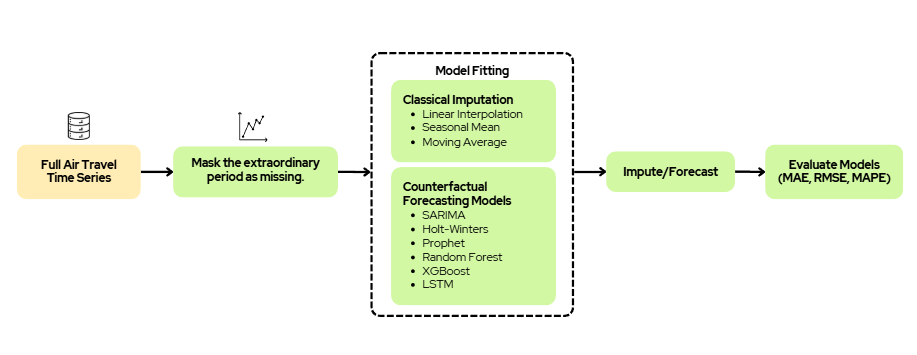

In [ ]:
covid_start = '2020-07-01'
covid_end = '2021-12-01'
series = df['departing__international_passengers'].copy()

series_masked = series.copy()
series_masked.loc[(series_masked.index >= covid_start) & (series_masked.index <= covid_end)] = None

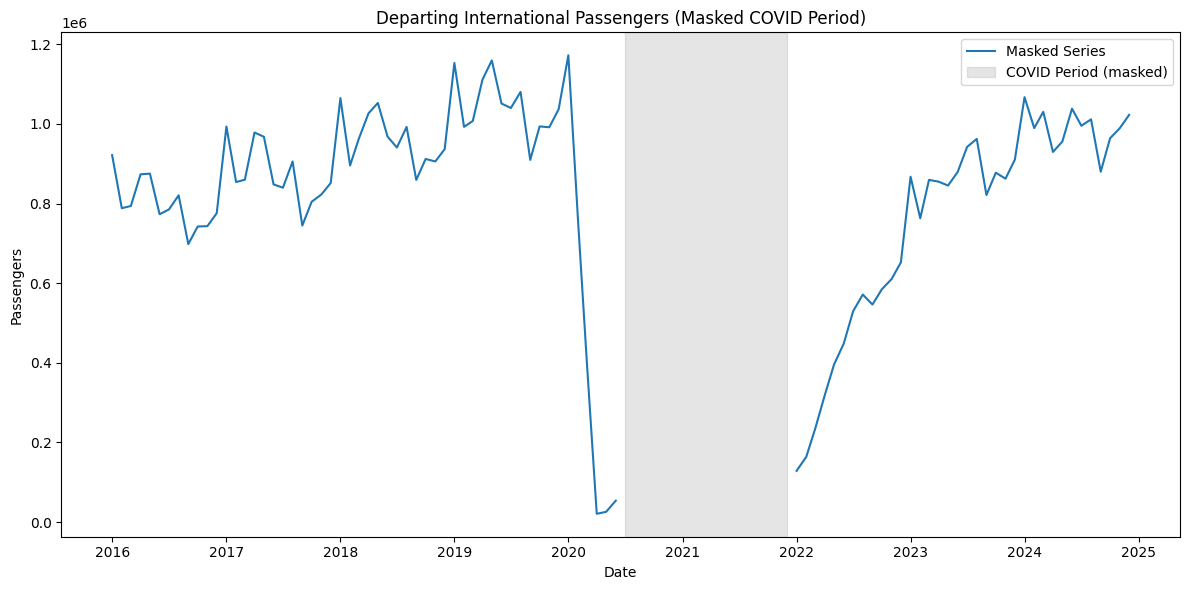

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(series_masked, label='Masked Series', color='tab:blue')
plt.axvspan(pd.Timestamp(covid_start), pd.Timestamp(covid_end), color='gray', alpha=0.2, label='COVID Period (masked)')
plt.title('Departing International Passengers (Masked COVID Period)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.tight_layout()
plt.show()

## On to model fitting!

## First iteration: Imputation and forecasting without event awareness

### Classical Imputation Methods

#### Linear Imputation

In [ ]:
imputed_linear = series_masked.interpolate(method='linear')

#### Seasonal Mean

In [ ]:
mask_not_covid = ~((series.index >= covid_start) & (series.index <= covid_end))
filtered = series.loc[mask_not_covid]
month_means = filtered.groupby(filtered.index.month).mean()

mask_not_covid = ~((series.index >= covid_start) & (series.index <= covid_end))
filtered = series.loc[mask_not_covid]
month_means = filtered.groupby(filtered.index.month).mean()

imputed_seasonal = series_masked.copy()
for month in range(1, 13):
    month_mask = (imputed_seasonal.index.month == month) & (imputed_seasonal.isna())
    imputed_seasonal.loc[month_mask] = month_means[month]

#### Moving Average

In [ ]:
imputed_ma = series_masked.fillna(series_masked.rolling(window=3, center=True, min_periods=1).mean())

### Counterfactual Forecasting Methods

#### SARIMA

In [ ]:
train = series.loc[series.index < covid_start]
model = sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
fit = model.fit(disp=False)

n_forecast = len(series.loc[(series.index >= covid_start) & (series.index <= covid_end)])
forecast = fit.get_forecast(steps=n_forecast)
counterfactual_sarima = pd.Series(
    forecast.predicted_mean.values,
    index=series.loc[(series.index >= covid_start) & (series.index <= covid_end)].index
)

imputed_sarima = series_masked.copy()
imputed_sarima.loc[(imputed_sarima.index >= covid_start) & (imputed_sarima.index <= covid_end)] = counterfactual_sarima

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


#### Holt-Winters

In [ ]:
train_hw = series.loc[series.index < covid_start]
hw_model = ExponentialSmoothing(train_hw, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

hw_forecast = hw_fit.forecast(steps=len(series.loc[(series.index >= covid_start) & (series.index <= covid_end)]))
counterfactual_hw = pd.Series(
    hw_forecast.values,
    index=series.loc[(series.index >= covid_start) & (series.index <= covid_end)].index
)
imputed_hw = series_masked.copy()
imputed_hw.loc[(imputed_hw.index >= covid_start) & (imputed_hw.index <= covid_end)] = counterfactual_hw

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Prophet

In [ ]:
prophet_df = series.reset_index().rename(columns={'date':'ds', 'departing__international_passengers':'y'})
prophet_train = prophet_df[prophet_df['ds'] < covid_start]

m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(series) - len(prophet_train), freq='MS')
forecast = m.predict(future)

mask_covid_prophet = (forecast['ds'] >= covid_start) & (forecast['ds'] <= covid_end)
counterfactual_prophet = pd.Series(
    forecast.loc[mask_covid_prophet, 'yhat'].values,
    index=series.loc[(series.index >= covid_start) & (series.index <= covid_end)].index
)
imputed_prophet = series_masked.copy()
imputed_prophet.loc[(imputed_prophet.index >= covid_start) & (imputed_prophet.index <= covid_end)] = counterfactual_prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5u73pxu/uvgpbsii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5u73pxu/k144szlq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2237', 'data', 'file=/tmp/tmpt5u73pxu/uvgpbsii.json', 'init=/tmp/tmpt5u73pxu/k144szlq.json', 'output', 'file=/tmp/tmpt5u73pxu/prophet_modelmrojtqc6/prophet_model-20250831140949.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:09:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
def create_lagged_features(s, lags=[1,2]):
    df_feat = pd.DataFrame({'y': s})
    for lag in lags:
        df_feat[f'lag_{lag}'] = s.shift(lag)
    df_feat['month'] = s.index.month
    return df_feat

df_feat = create_lagged_features(series)
mask_train = (df_feat.index < covid_start) & (df_feat.notnull().all(axis=1))
mask_pred = (df_feat.index >= covid_start) & (df_feat.notnull().all(axis=1))

X_train = df_feat.loc[mask_train].drop(columns=['y'])
y_train = df_feat.loc[mask_train, 'y']
X_pred = df_feat.loc[mask_pred].drop(columns=['y'])

#### Random Forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_pred)

counterfactual_rf = pd.Series(rf_pred, index=X_pred.index)
imputed_rf = series_masked.copy()
imputed_rf.loc[counterfactual_rf.index] = counterfactual_rf

#### XGBoost

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_pred)

counterfactual_xgb = pd.Series(xgb_pred, index=X_pred.index)
imputed_xgb = series_masked.copy()
imputed_xgb.loc[counterfactual_xgb.index] = counterfactual_xgb

### LSTM

In [ ]:
mask_pre_covid = series.index < covid_start
mask_covid = (series.index >= covid_start) & (series.index <= covid_end)
series_values = series.values.reshape(-1, 1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_values).flatten()
lookback = 12
X, y = [], []
for i in range(lookback, sum(mask_pre_covid)):
    X.append(series_scaled[i-lookback:i])
    y.append(series_scaled[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=8, verbose=1)
inputs = series_scaled[sum(mask_pre_covid)-lookback:sum(mask_pre_covid)].tolist()
preds_scaled = []
for _ in range(mask_covid.sum()):
    x_input = np.array(inputs[-lookback:]).reshape((1, lookback, 1))
    yhat = model.predict(x_input, verbose=0)[0,0]
    preds_scaled.append(yhat)
    inputs.append(yhat)
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
imputed_lstm = series.copy()
imputed_lstm.loc[mask_covid] = preds

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4737
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2734
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1428
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0552
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0547
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0613
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0571
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0629
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0569
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0588
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0383
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0592
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0693
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0511
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0502
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━

/tmp/ipython-input-2185478677.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[483798.44 493049.47 494131.34 499429.4  505112.03 510988.56 516007.3
 518835.34 526164.56 537555.06 552923.8  567387.56 580815.1  588800.94
 596424.94 603817.4  610894.5  617638.06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  imputed_lstm.loc[mask_covid] = preds


### It's time to evaluate!

In [ ]:
imputed_ma = series_masked.copy()
imputed_ma = imputed_ma.fillna(imputed_ma.rolling(window=3, center=True, min_periods=1).mean())
imputed_ma = imputed_ma.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-3153057238.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imputed_ma = imputed_ma.fillna(method='ffill').fillna(method='bfill')


In [ ]:
models = {
    "Linear Interpolation": imputed_linear,
    "Seasonal Mean": imputed_seasonal,
    "Moving Average": imputed_ma,
    "SARIMA": imputed_sarima,
    "Holt-Winters": imputed_hw,
    "Prophet": imputed_prophet,
    "Random Forest": imputed_rf,
    "XGBoost": imputed_xgb,
    "LSTM": imputed_lstm
}

In [ ]:
mask_covid = (series.index >= covid_start) & (series.index <= covid_end)
actual = series[mask_covid]

def evaluate_method(imputed):
    pred = imputed[mask_covid]
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    }

In [ ]:
results = {}
for name, imputed in models.items():
    results[name] = evaluate_method(imputed)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("RMSE")
results_df

,MAE,RMSE,MAPE (%)
Linear Interpolation,1.155966e+04,1.385729e+04,11.732917
Random Forest,2.643232e+04,3.489417e+04,29.890864
Moving Average,4.423033e+04,4.754806e+04,42.764418
XGBoost,6.626429e+04,6.880604e+04,69.975039
LSTM,4.425748e+05,4.434961e+05,443.771457
SARIMA,3.669903e+05,4.595147e+05,332.237564
Seasonal Mean,7.322701e+05,7.343597e+05,743.718374
Prophet,7.252422e+05,7.351604e+05,741.903651
Holt-Winters,1.272924e+06,1.459467e+06,1171.083557


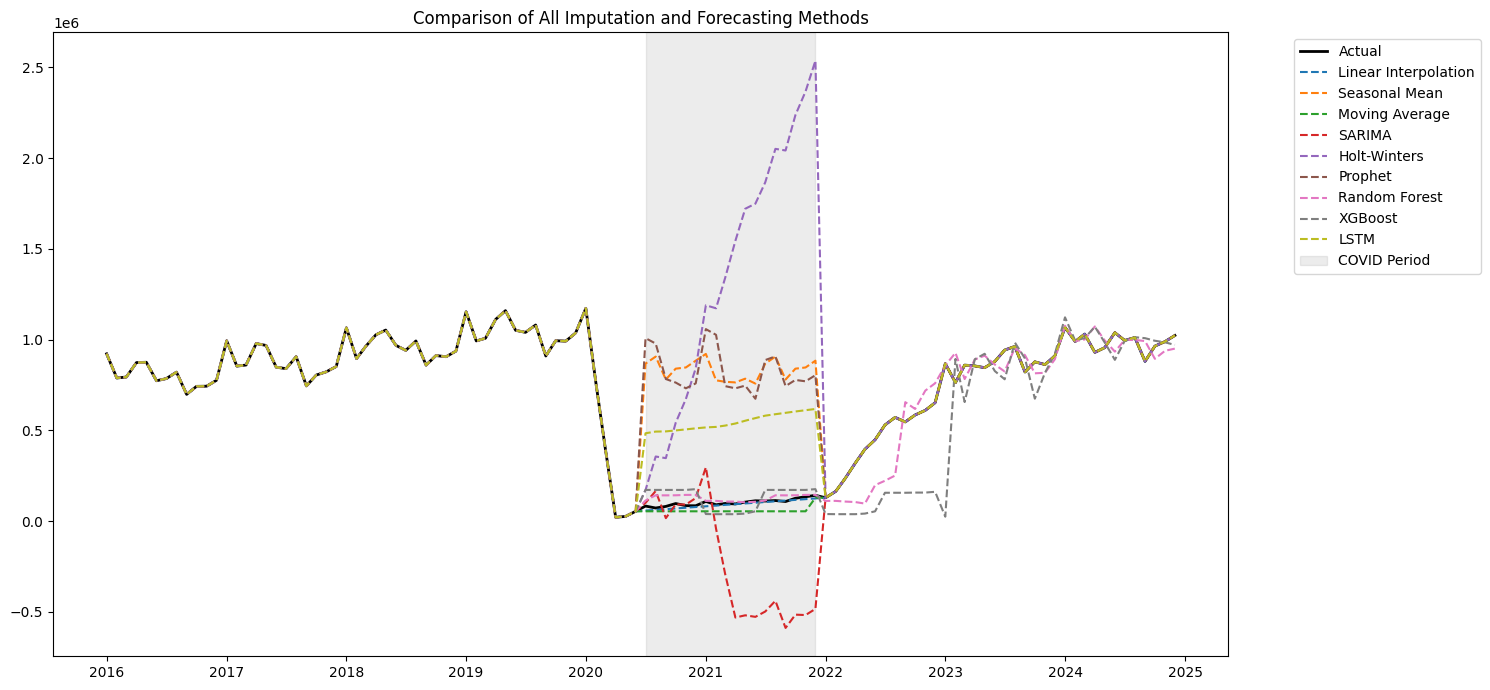

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(series, label="Actual", color="black", linewidth=2)

for name, imputed in models.items():
    plt.plot(imputed, label=name, linestyle='--')

plt.axvspan(pd.Timestamp(covid_start), pd.Timestamp(covid_end), color='gray', alpha=0.15, label='COVID Period')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Comparison of All Imputation and Forecasting Methods")
plt.tight_layout()
plt.show()

Findings
* Simple methods outperform advanced models: Linear interpolation yielded the lowest error across all metrics (MAE: 11,560; MAPE: 11.7%), significantly outperforming more complex forecasting models and even classical seasonal methods.
* Moving average performed moderately well (MAE: 44,230; MAPE: 42.8%), likely because it can follow the local trend, but not abrupt shifts.
* Traditional time series models (SARIMA, Holt-Winters, Prophet, Seasonal Mean) all failed to capture the drop, producing very high errors (MAPE: 332% to 1171%). This reflects their reliance on pre-COVID seasonality and trend, leading to strong over-prediction during the extraordinary period.
* Machine learning and deep learning models (Random Forest, XGBoost, LSTM) also struggled, with LSTM and XGBoost among the least accurate. These models extrapolated pre-pandemic dynamics into the COVID period, missing the true pattern of the shock.

This underscores that, in the absence of explicit event indicators or partial shock information, simple interpolation can outperform even advanced forecasting and machine learning methods during extreme disruptions. All traditional and ML models (trained only on pre-event data) fail to capture the true magnitude and shape of the COVID-19 drop.

## Second iteration: Event-aware models


For the second iteration, I enhanced each model by providing more contextual information. In addition to an explicit COVID flag marking the extraordinary period, I engineered several lagged features—such as prior values from one and 2 months ago, as well as rolling means. These features give the models a clearer sense of both recent trends and historical seasonality.

Random Forest, XGBoost, LSTM, and Prophet were each trained on the full dataset, now with the COVID flag and lagged features as additional inputs. This setup allows the models to leverage both the timing of the disruption and prior behavior in the series when making predictions for the masked period.

In [ ]:
covid_flag = ((series.index >= covid_start) & (series.index <= covid_end)).astype(int)

In [ ]:
def create_lagged_features(s, lags=[1, 2]):
    df_feat = pd.DataFrame({'y': s})
    for lag in lags:
        df_feat[f'lag_{lag}'] = s.shift(lag)
    df_feat['rolling_mean_2'] = s.rolling(window=2).mean()
    df_feat['month'] = s.index.month
    return df_feat

df_feat = create_lagged_features(series)
df_feat['covid_flag'] = covid_flag

mask_train = (df_feat.index < covid_start) & (df_feat.notnull().all(axis=1))
mask_pred = (df_feat.index >= covid_start) & (df_feat.notnull().all(axis=1))

X_train = df_feat.loc[mask_train].drop(columns=['y'])
y_train = df_feat.loc[mask_train, 'y']
X_pred = df_feat.loc[mask_pred].drop(columns=['y'])

### RF

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_pred)

imputed_rf_event = series.copy()
imputed_rf_event.loc[X_pred.index] = rf_pred

/tmp/ipython-input-2028073900.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  78098.34   78098.34   78098.34   78540.12   78999.76   79325.66
  134877.66  134877.66  134877.66   92396.62   67925.86   78098.34
   78098.34   78098.34   78098.34   78294.37   77762.39   78088.29
  133823.38  133823.38  133823.38   88916.75   81269.06  201060.13
  310332.77  310687.87  351126.37  358890.13  399471.88  415726.49
  764687.76  783401.13  793826.17  870151.61  867956.38  873234.69
  918261.98  960179.37  882406.58  862511.4   894931.02  915794.89
 1032565.11 1051312.66 1003974.23  959228.29  959759.05  993591.08
 1010210.65  988429.07  927541.06  928753.02  979046.37  995348.02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  imputed_rf_event.loc[X_pred.index] = rf_pred


### XGB

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_pred)

imputed_xgb_event = series.copy()
imputed_xgb_event.loc[X_pred.index] = xgb_pred

/tmp/ipython-input-3910149233.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  53693.83    53699.605   53697.645   53700.3     53700.3     53679.547
   53531.39    53531.39    53531.39    53531.39    53693.895   53693.895
   53693.83    53699.605   53697.645   53700.3     53700.3     53679.547
   53531.39    53531.39    53531.39    53531.39    53693.895   49042.28
   21048.377   21062.787   21060.826   21244.934   21244.934   21224.178
  531455.2    767239.06   810475.3    861188.7    859373.7    873801.4
  919184.25   979346.7    851281.3    848990.8    847889.06   915528.1
 1047042.25  1008982.8   1006935.     942757.7    951557.9   1003630.
 1017550.94   994770.1    921375.44   938712.94   986574.8    991947.6  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  imputed_xgb_event.loc[X_pred.index] = xgb_pred


### LSTM

In [ ]:
series_values = series.values.reshape(-1, 1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_values).flatten()
covid_flag_arr = covid_flag

lookback = 3
X, y = [], []
for i in range(lookback, sum(mask_pre_covid)):
    X_window = np.column_stack([
        series_scaled[i-lookback:i],
        covid_flag_arr[i-lookback:i]
    ])
    X.append(X_window)
    y.append(series_scaled[i])
X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], lookback, 2))

model = Sequential([
    LSTM(32, input_shape=(lookback, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=8, verbose=1)

inputs_series = series_scaled[sum(mask_pre_covid)-lookback:sum(mask_pre_covid)].tolist()
inputs_covid = covid_flag_arr[sum(mask_pre_covid)-lookback:sum(mask_pre_covid)].tolist()
preds_scaled = []
for i in range(mask_covid.sum()):
    x_input = np.column_stack([
        inputs_series[-lookback:],
        inputs_covid[-lookback:]
    ]).reshape((1, lookback, 2))
    yhat = model.predict(x_input, verbose=0)[0,0]
    preds_scaled.append(yhat)
    inputs_series.append(yhat)
    inputs_covid.append(1)

preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
imputed_lstm_event = series.copy()
imputed_lstm_event.loc[mask_covid] = preds

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6113
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4795 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3709 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2930  
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1885 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1292 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0701 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0260 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0450 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0481 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0280 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0378  
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0378 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

/tmp/ipython-input-897903130.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 268140.22  355285.3   470149.4   612608.7   693099.94  780435.56
  862880.1   927401.94  990055.94 1046174.56 1094837.9  1139775.9
 1179821.2  1215451.1  1247655.9  1276360.6  1301986.6  1324926.4 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  imputed_lstm_event.loc[mask_covid] = preds


### Prophet

In [ ]:
df_prophet = df_feat.reset_index().rename(columns={'date':'ds', 'departing__international_passengers':'y'})
df_prophet = df_prophet[['ds', 'y', 'covid_flag']]
# df_prophet['covid_flag'] = df_feat['covid_flag'].values

m = Prophet(yearly_seasonality=True)
m.add_regressor('covid_flag')
m.fit(df_prophet)

future = df_prophet[['ds', 'covid_flag']]
forecast = m.predict(future)

imputed_prophet_event = series.copy()
imputed_prophet_event.loc[:] = forecast['yhat'].values

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5u73pxu/nqghinwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5u73pxu/md4tbx4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75043', 'data', 'file=/tmp/tmpt5u73pxu/nqghinwy.json', 'init=/tmp/tmpt5u73pxu/md4tbx4z.json', 'output', 'file=/tmp/tmpt5u73pxu/prophet_model5wzuxux3/prophet_model-20250831142205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/tmp/ipython-input-3089533506.py:13: Fut

### Evaluation part 2

In [ ]:
models_event = {
    "Random Forest (COVID flag)": imputed_rf_event,
    "XGBoost (COVID flag)": imputed_xgb_event,
    "LSTM (COVID flag)": imputed_lstm_event,
    "Prophet (COVID flag)": imputed_prophet_event
}

In [ ]:
results_event = {}
for name, imputed in models_event.items():
    preds = imputed[mask_covid]
    if preds.isna().any():
        print(f"Skipping {name} due to NaNs in prediction.")
        continue
    results_event[name] = evaluate_method(imputed)

results_event_df = pd.DataFrame(results_event).T
results_event_df = results_event_df.sort_values("RMSE")
results_event_df

,MAE,RMSE,MAPE (%)
Random Forest (COVID flag),27055.956111,33033.721284,24.526098
Prophet (COVID flag),42337.625092,48341.857756,44.534600
XGBoost (COVID flag),48420.621962,51814.282485,45.732500
LSTM (COVID flag),830534.461806,886598.002991,791.360064


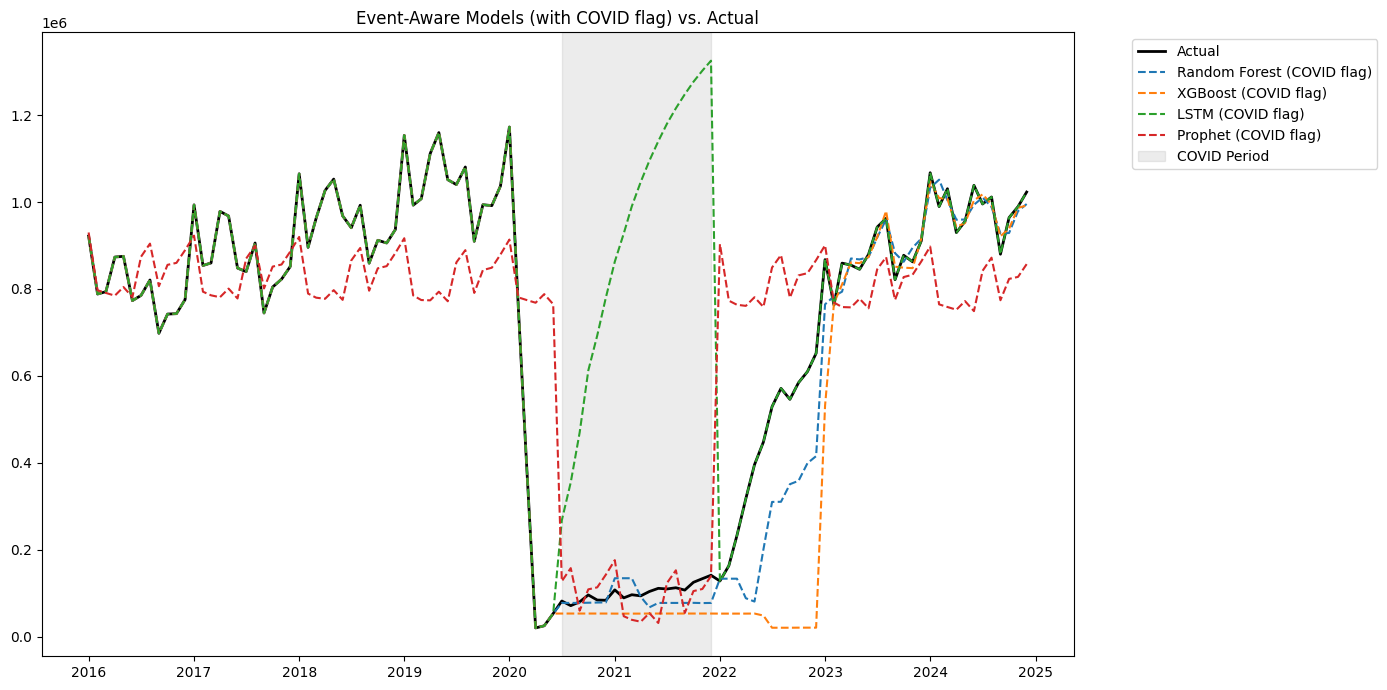

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(series, label='Actual', color='black', linewidth=2)
for name, imputed in models_event.items():
    plt.plot(imputed, label=name, linestyle='--')
plt.axvspan(pd.Timestamp(covid_start), pd.Timestamp(covid_end), color='gray', alpha=0.15, label='COVID Period')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Event-Aware Models (with COVID flag) vs. Actual")
plt.tight_layout()
plt.show()

Findings:

* Random Forest with COVID flag achieved the lowest error across all metrics (MAE: 27,056; MAPE: 24.5%), and was the only model with MAPE below 25%. This indicates a strong ability to utilize the event flag and lags to track the abrupt drop and partial recovery during the COVID period.

* Prophet and XGBoost models also benefited from event-awareness, with MAPEs of 44.5% and 45.7% respectively—much improved over their performance without the flag, though less accurate than Random Forest.

* LSTM, while event-aware, performed substantially worse in this configuration (MAPE: 791.4%), suggesting that for this dataset and window size, tree-based models more effectively exploited the available features to reconstruct the shock.

## Third Iteration: Event-Aware Imputation with Exogenous feature

In [ ]:
trends = pd.read_csv('google_trends.csv')
trends['Month'] = pd.to_datetime(trends['Month'])
trends.set_index('Month', inplace=True)
trends = trends.rename(columns={"flight: (Philippines)": "flight"})
trends = trends.sort_index()

/tmp/ipython-input-2074750794.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


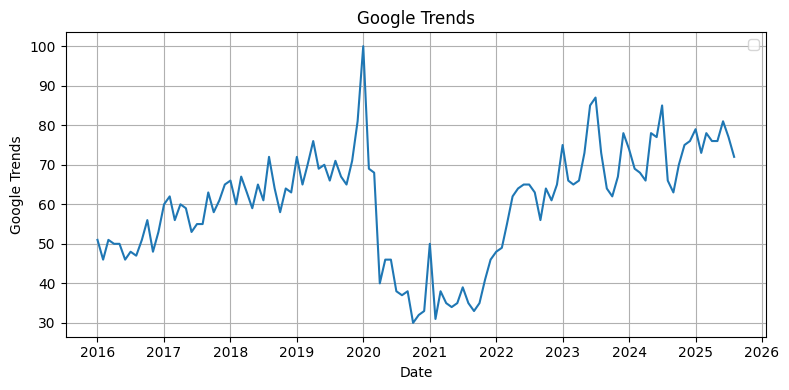

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(trends)
plt.xlabel('Date')
plt.ylabel('Google Trends')
plt.title('Google Trends')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_feat['google_trends_flight'] = trends['flight'].reindex(df_feat.index).fillna(method='ffill')

/tmp/ipython-input-1336245237.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat['google_trends_flight'] = trends['flight'].reindex(df_feat.index).fillna(method='ffill')


In [ ]:
df_feat

,y,lag_1,lag_2,rolling_mean_2,month,covid_flag,google_trends_flight
date,,,,,,,
2016-01-01,921618,NaN,NaN,NaN,1,0,51
2016-02-01,788340,921618.0,NaN,854979.0,2,0,46
2016-03-01,793846,788340.0,921618.0,791093.0,3,0,51
2016-04-01,873412,793846.0,788340.0,833629.0,4,0,50
2016-05-01,875112,873412.0,793846.0,874262.0,5,0,50
...,...,...,...,...,...,...,...
2024-08-01,1011542,995418.0,1038331.0,1003480.0,8,0,66
2024-09-01,879991,1011542.0,995418.0,945766.5,9,0,63
2024-10-01,964120,879991.0,1011542.0,922055.5,10,0,70


In [ ]:
df_feat = df_feat.dropna()

mask_train = (df_feat.index < covid_start) & (df_feat.notnull().all(axis=1))
mask_pred = (df_feat.index >= covid_start) & (df_feat.notnull().all(axis=1))

X_train = df_feat.loc[mask_train].drop(columns=['y'])
y_train = df_feat.loc[mask_train, 'y']
X_pred = df_feat.loc[mask_pred].drop(columns=['y'])

### RF

In [ ]:
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_pred)

imputed_rf_exog = series.copy()
imputed_rf_exog.loc[X_pred.index] = rf_pred

/tmp/ipython-input-1798399954.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  77565.98666667   77565.98666667   77465.95333333   77613.21333333
   77772.38         77785.33        140677.65         99778.92333333
   99778.92333333   75693.93666667   72597.63666667   77565.98666667
   77565.98666667   77565.98666667   77465.95333333   77416.61333333
   76694.34         87377.37666667  139677.02333333  139677.02333333
  144626.36        156517.23666667  161431.55666667  246308.88333333
  317409.37333333  324119.05        370372.45666667  389314.57
  447948.38666667  454266.89666667  780762.74666667  800433.83333333
  799095.78666667  883688.14333333  872332.95        880131.0475
  918399.14416667  962388.04793651  891684.09727778  867282.95555556
  899693.9965      916480.06288889 1038281.65611111 1053435.42666667
 1010960.09333333  964572.46238095  958040.15515873 1007638.9075
 1030170.71888889  98

###XGB

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_pred)

imputed_xgb_exog = series.copy()
imputed_xgb_exog.loc[X_pred.index] = xgb_pred

/tmp/ipython-input-2834082685.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  51212.39    51259.734   51259.734   59269.11    59269.11    59177.113
   53441.906   51057.113   51057.113   51057.113   51057.113   51212.39
   51212.39    51259.734   51259.734   59269.11    59269.11    62101.76
   53475.105   53475.105   53441.906   53348.59    53344.395   52146.266
   25112.062   25221.174   25345.062   41055.043   41351.926   40977.816
  818146.2    787095.8    805428.8    871537.94   850623.9    868901.2
  921965.8    994157.4    894489.06   852868.44   849817.     927031.2
 1055224.4   1016543.8    997842.6    950524.56   954941.9   1006787.7
 1037881.5    976744.75   884140.3    931487.2    980167.2    987693.2  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  imputed_xgb_exog.loc[X_pred.index] = xgb_pred


### LSTM

In [ ]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(df_feat['y'].values.reshape(-1, 1)).flatten()
features = [
    series_scaled,
    df_feat['covid_flag'].values,
    df_feat['lag_1'].values,
    df_feat['lag_2'].values,
    df_feat['month'].values,
    df_feat['google_trends_flight'].values
]
X_all = np.column_stack(features)
lookback = 3
X_lstm, y_lstm = [], []
for i in range(lookback, len(X_all)):
    X_lstm.append(X_all[i-lookback:i, :])
    y_lstm.append(series_scaled[i])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

model = Sequential([
    LSTM(64, input_shape=(lookback, X_lstm.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_lstm, y_lstm, epochs=80, batch_size=8, verbose=1)

mask_pred_arr = df_feat.index[mask_pred]
n_pred = mask_pred.sum()
last_i = np.where(df_feat.index < pd.to_datetime(covid_start))[0][-1]
window = X_all[last_i-lookback+1:last_i+1, :]
preds_scaled = []
for i in range(n_pred):
    x_input = window[-lookback:, :].copy()
    x_input[:, 1] = 1  # covid_flag=1
    yhat = model.predict(x_input[np.newaxis, :, :], verbose=0)[0,0]
    preds_scaled.append(yhat)
    new_row = [
        yhat,
        1,
        window[-1,0],
        window[-2,0] if window.shape[0] >= 2 else window[0,0],
        window[-1,4],   # month, unchanged
        window[-1,5]
    ]
    window = np.vstack([window, new_row])[1:]
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
imputed_lstm_exog = series.copy()
imputed_lstm_exog.loc[mask_pred_arr] = preds

Epoch 1/80


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9221
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6065 
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3914 
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2396 
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1583 
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1333 
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1130 
Epoch 8/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1258 
Epoch 9/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1079 
Epoch 10/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0952 
Epoch 11/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1190
Epoch 12/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0938 
Epoch 13/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0894 
Epoch 14/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0795 
Epoch 15/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0986 
Epoch 16/80
13/13

/tmp/ipython-input-3493198769.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  50423.402  405965.75   -43125.203 -579503.7   -574851.56  -565440.1
 -558186.1   -558773.7   -559232.3   -559310.7   -559287.75  -559277.6
 -559277.4   -559278.06  -559278.4   -559278.3   -559278.3   -559278.3
 -559278.3   -559278.3   -559278.3   -559278.3   -559278.3   -559278.3
 -559278.3   -559278.3   -559278.3   -559278.3   -559278.3   -559278.3
 -559278.3   -559278.3   -559278.3   -559278.3   -559278.3   -559278.3
 -559278.3   -559278.3   -559278.3   -559278.3   -559278.3   -559278.3
 -559278.3   -559278.3   -559278.3   -559278.3   -559278.3   -559278.3
 -559278.3   -559278.3   -559278.3   -559278.3   -559278.3   -559278.3  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  imputed_lstm_exog.loc[mask_pred_arr] = preds


### Prophet

In [ ]:
df_prophet = df_feat.reset_index().rename(columns={'date':'ds', 'departing__international_passengers':'y'})
df_prophet = df_prophet[['ds', 'y', 'covid_flag', 'google_trends_flight']]

m = Prophet(yearly_seasonality=True)
m.add_regressor('covid_flag')
m.add_regressor('google_trends_flight')
m.fit(df_prophet)

future = df_prophet[['ds', 'covid_flag', 'google_trends_flight']]
forecast = m.predict(future)

imputed_prophet_exog = series.copy()
covid_idx_prophet = (series.index >= covid_start) & (series.index <= covid_end)
imputed_prophet_exog.loc[covid_idx_prophet] = forecast.loc[
    (forecast['ds'] >= pd.to_datetime(covid_start)) & (forecast['ds'] <= pd.to_datetime(covid_end)),
    'yhat'
].values

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5u73pxu/3ew13pfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5u73pxu/zfjape68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86547', 'data', 'file=/tmp/tmpt5u73pxu/3ew13pfr.json', 'init=/tmp/tmpt5u73pxu/zfjape68.json', 'output', 'file=/tmp/tmpt5u73pxu/prophet_modelixxrud1c/prophet_model-20250831142259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/tmp/ipython-input-1541907969.py:14: Fut

### Evaluation pt 3

In [ ]:
models_exog = {
    "Random Forest (with exog)": imputed_rf_exog,
    "XGBoost (with exog)": imputed_xgb_exog,
    "LSTM (with exog)": imputed_lstm_exog,
    "Prophet (with exog)": imputed_prophet_exog
}
results_exog = {}
for name, imputed in models_exog.items():
    preds = imputed[mask_covid]
    if preds.isna().any():
        print(f"Skipping {name} due to NaNs in prediction.")
        continue
    results_exog[name] = evaluate_method(imputed)

results_exog_df = pd.DataFrame(results_exog).T
results_exog_df = results_exog_df.sort_values("RMSE")
results_exog_df

,MAE,RMSE,MAPE (%)
Random Forest (with exog),24102.989074,29780.816420,21.478926
XGBoost (with exog),47929.178819,50902.817129,45.480245
Prophet (with exog),67544.356220,82511.733071,69.567019
LSTM (with exog),584552.159071,616468.677736,568.548175


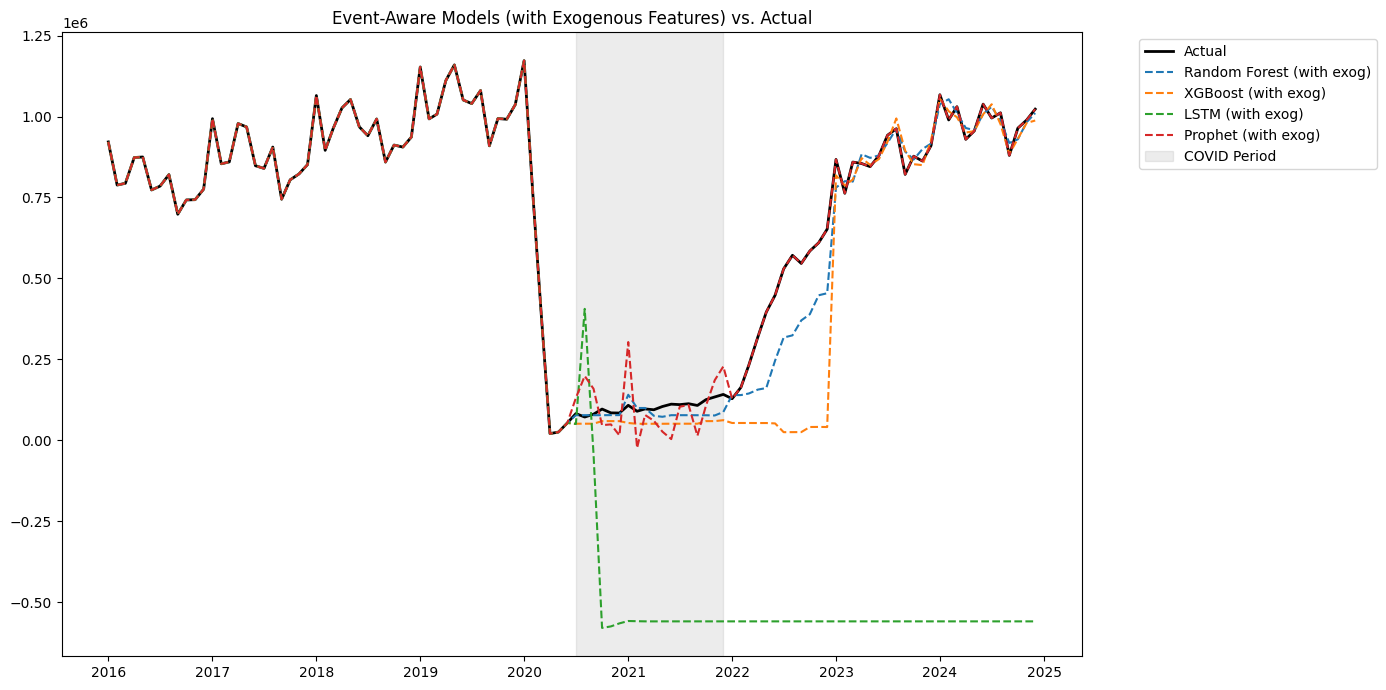

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(series, label='Actual', color='black', linewidth=2)
for name, imputed in models_exog.items():
    plt.plot(imputed, label=name, linestyle='--')
plt.axvspan(pd.Timestamp(covid_start), pd.Timestamp(covid_end), color='gray', alpha=0.15, label='COVID Period')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Event-Aware Models (with Exogenous Features) vs. Actual")
plt.tight_layout()
plt.show()

### Findings

* Random Forest with exogenous features achieved the lowest error across all metrics (MAE: 24,103; MAPE: 21.5%), and was the only model with MAPE below 25%. This demonstrates that Random Forest leveraged the additional exogenous information, along with lagged features, to track the abrupt drop and partial recovery during the COVID period.

* XGBoost and Prophet also incorporated the exogenous feature, but their MAPEs remained higher at 45.5% and 69.6% respectively, indicating less benefit from the additional input compared to Random Forest.

* LSTM, even with exogenous features, performed substantially worse (MAPE: 568.5%), reinforcing the observation that, in this setting, tree-based models are more robust for imputing extraordinary periods when supplied with engineered features.

## Conclusion

This study explored a range of imputation and forecasting methods to reconstruct air travel volumes during an extraordinary disruption. The findings highlight that, in this setting, simple approaches like linear interpolation can sometimes outperform more complex forecasting models, particularly when explicit information about the disruption is unavailable.

When event indicators (such as a COVID flag) or selected exogenous features were provided, tree-based models like Random Forest showed improved accuracy compared to other advanced approaches, but overall errors remained substantial. The addition of external signals such as Google Trends or engineered lagged features resulted in only marginal or inconsistent improvements.

While some methods achieved moderate error rates, many models still exhibited high MAPE during the extraordinary period, underscoring the challenge of imputing data under conditions that lie far outside the historical norm. These results suggest that both model choice and feature design play important roles, but neither is a guarantee of low error when faced with truly unprecedented events.

In the end, even with feature engineering and more sophisticated algorithms, filling in the blanks during a shock remains difficult. Sometimes, the simplest baseline methods hold up surprisingly well. For future extraordinary periods, having access to clear event indicators and understanding the limits of even advanced models are both essential.

In [ ]:
summary_df = pd.concat(
    [results_df, results_event_df, results_exog_df],
    axis=0,
    sort=False
).sort_values("RMSE").reset_index()
summary_df = summary_df.rename(columns={'index': 'Model'})
summary_df

,Model,MAE,RMSE,MAPE (%)
0,Linear Interpolation,1.155966e+04,1.385729e+04,11.732917
1,Random Forest (with exog),2.410299e+04,2.978082e+04,21.478926
2,Random Forest (COVID flag),2.705596e+04,3.303372e+04,24.526098
3,Moving Average,4.423033e+04,4.754806e+04,42.764418
4,Prophet (COVID flag),4.233763e+04,4.834186e+04,44.534600
5,XGBoost (with exog),4.792918e+04,5.090282e+04,45.480245
6,XGBoost (COVID flag),4.842062e+04,5.181428e+04,45.732500
7,Prophet (with exog),6.754436e+04,8.251173e+04,69.567019
8,Random Forest,9.912749e+04,1.043888e+05,100.249181
9,XGBoost,1.583098e+05,1.907324e+05,146.255504



## Recommendations for Future Studies

* Future work should focus on capturing direct signals of disruptions—such as policy changes, travel bans, or operational announcements—which are often more informative than generic external data or search trends.

* While Google Trends and basic economic indicators provided limited improvement here, future research could test additional real-world signals (mobility indices, policy stringency, booking data, or social sentiment) that might better capture passenger behavior during extraordinary periods.

* Combining simple methods like linear interpolation with advanced models may help constrain over- or under-estimation during shocks, particularly when event information is incomplete.

* Extending this analysis to other types of disruptions (such as natural disasters, strikes, or economic crises) can help determine how robust each approach is in different real-world scenarios.